# Preparation of the geographical data

The data for region visualization of Uganda, Rwanda and Madagascar was obtained in shp format, and exported to csv files in [WKT format](https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry) using [QGIS](https://qgis.org/pl/site/forusers/download.html). The following data sources were used:
 - [Madagascar administrative boundaries (CC0; source: The Humanitarian Data Exchange)](https://data.humdata.org/dataset/26fa506b-0727-4d9d-a590-d2abee21ee22/resource/ed94d52e-349e-41be-80cb-62dc0435bd34)
 - [Rwanda administrative boundaries (CC4.0; source: The World Bank Data Catalog)](https://datacatalog.worldbank.org/search/dataset/0041453/Rwanda-Admin-Boundaries-and-Villages)
 - [Uganda administrative boundaries (CC0; source data.world)](https://data.world/ocha-rosea/6d6d1495-196b-49d0-86b9-dc9022cde8e7)

In [2]:
library(tidyverse)

### 1. Importing geometry data of the administrative regions

The CSV files contain data in [WKT](https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry) format and need to be parsed properly to read into dataframe in format appropriate for ggplot2. 

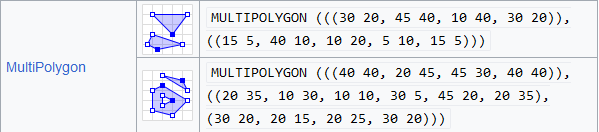

The following function takes a dataframe of the WKT geometry (polygons with holes, MULTIPOLYGON entity only) and transforms them into the clean R dataframe using RegEx. Although it can handle holes while reading CSV file, it does not process holes for placing them in the resulting dataframe. (Holes were not present in the processed geometry, and such functionality was considered redundant.)

As the geometry dataframe later will be merged (joined) with population data, the path idexes (`path.id`) and point indexes (`point.ix`) within a path need to be added to avoid problems with displaying geometries after merging. To avoid problems with drawing regions using gglpot2 it is required to sort resulting dataframe with respect to the `path.id` and `point.ix` after merging.

In [3]:
parse_wkt_multipolygon <- function(df.wkt){
    
    reg.ex1 <- "\\((?:[^)(]*(?R)?)*+\\)" # extract content on a first level - polygons with holes
    reg.ex2 <- '\\((.*?)\\)' # extract content on the second level
    
    N <- nrow(df.wkt)
    tmp.df <- NULL
    path.id <- 0 # not needes as in this project no holes are given
    for (i in 1:N){
        r <- df.wkt[i,]
        region <- r[[2]]
        p <- r[[1]] # WKT multipolygon
    
        # processing
        p <- str_remove_all(str_remove_all(p, fixed("MULTIPOLYGON (")),"\\)$")
        p <- regmatches(p, gregexpr(reg.ex1, p, perl = TRUE))[[1]]
        p <- str_extract_all(p,reg.ex2)

        for (j in 1:length(p)){
            if (length(p[[j]])>1) {
                warning("Function does not handle holes. Parsing WKT MULTIPOLYGON holes from CSV (generated from shapefile) requires implementation")
            }

            path.id <- path.id + 1 
            k <- 1
            xy <- str_split_fixed(str_split_1(str_remove_all(p[[j]][k],"\\(|\\)"),",")," ",2) # finally, the coordinates

             #for (k in 2:length(p[[j]]){
             #    # process holes geometry #TODO if needed in future
             #}
     
            if (is.null(tmp.df)){
                   tmp.df <-  data.frame(x=as.numeric(xy[,1]),y=as.numeric(xy[,2]),region=region,path.id=path.id,point.ix=1:nrow(xy)) 
            } else {  
                   tmp.df <-  rbind(tmp.df,data.frame(x=as.numeric(xy[,1]),y=as.numeric(xy[,2]),region=region,path.id=path.id,point.ix=1:nrow(xy)) )
            }
        
       }   # for (j in 1:length(p))   
     } # for (i in 1:N)

     return(tmp.df)

}

In [4]:
df.rwanda <- parse_wkt_multipolygon(read_csv2("data/geo/rwanda_regions.csv"))
df.uganda <- parse_wkt_multipolygon(read_csv2("data/geo/uganda_regions.csv"))
df.madagascar <- parse_wkt_multipolygon(read_csv2("data/geo/madagascar_regions.csv"))

ℹ Using "','" as decimal and "'.'" as grouping mark. Use `read_delim()` for more control.

Rows: 5 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr (2): WKT, ADM1_EN

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
ℹ Using "','" as decimal and "'.'" as grouping mark. Use `read_delim()` for more control.

Rows: 4 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr (2): WKT, ADM1_EN

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
ℹ Using "','" as decimal and "'.'" as grouping mark. Use `read_delim()` for more control.

Rows: 22 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr (2): WKT, ADM1_EN

ℹ Us

### 2. Adjusting the imported data for proper name alignment with population data

In [5]:
df.uganda["country"] <- "Uganda"

df.rwanda["country"] <- "Rwanda"
df.rwanda[df.rwanda$region=='Kigali City','region'] <- 'City of Kigali' # adjusting the names to be the same as in population data

df.madagascar["country"] <- "Madagascar"
df.madagascar[df.madagascar$region=='Alaotra Mangoro','region'] <- 'Alaotra-Mangoro' # adjusting the names to be the same as in population data
df.madagascar[df.madagascar$region=='Amoron I Mania','region'] <- "Amoron'i Mania"
df.madagascar[df.madagascar$region=='Atsimo Andrefana','region'] <- "Atsimo-Andrefana"
df.madagascar[df.madagascar$region=='Atsimo Atsinanana','region'] <- "Atsimo-Atsinanana"
df.madagascar[df.madagascar$region=='Haute Matsiatra','region'] <- "Haute Matsiatra (Matsiatra Ambony)"
df.madagascar[df.madagascar$region=='Vatovavy Fitovinany','region'] <- "Vatovavy-Fitovinany"

### 3. Adjusting path.ids, so they do not overlap between different countries

In [6]:
df.uganda$path.id <- df.uganda$path.id + max(df.rwanda$path.id)
df.madagascar$path.id <- df.madagascar$path.id + max(df.uganda$path.id)

df.geo.regions <- rbind(df.uganda,df.rwanda,df.madagascar)

head(df.geo.regions)

,x,y,region,path.id,point.ix,country
,<dbl>,<dbl>,<chr>,<dbl>,<int>,<chr>
1,32.22046,1.670968,Central,64,1,Uganda
2,32.22140,1.670771,Central,64,2,Uganda
3,32.22305,1.670426,Central,64,3,Uganda
4,32.23025,1.671126,Central,64,4,Uganda
5,32.23222,1.669040,Central,64,5,Uganda
6,32.23661,1.667703,Central,64,6,Uganda


#### Plotting the imported geometrical data

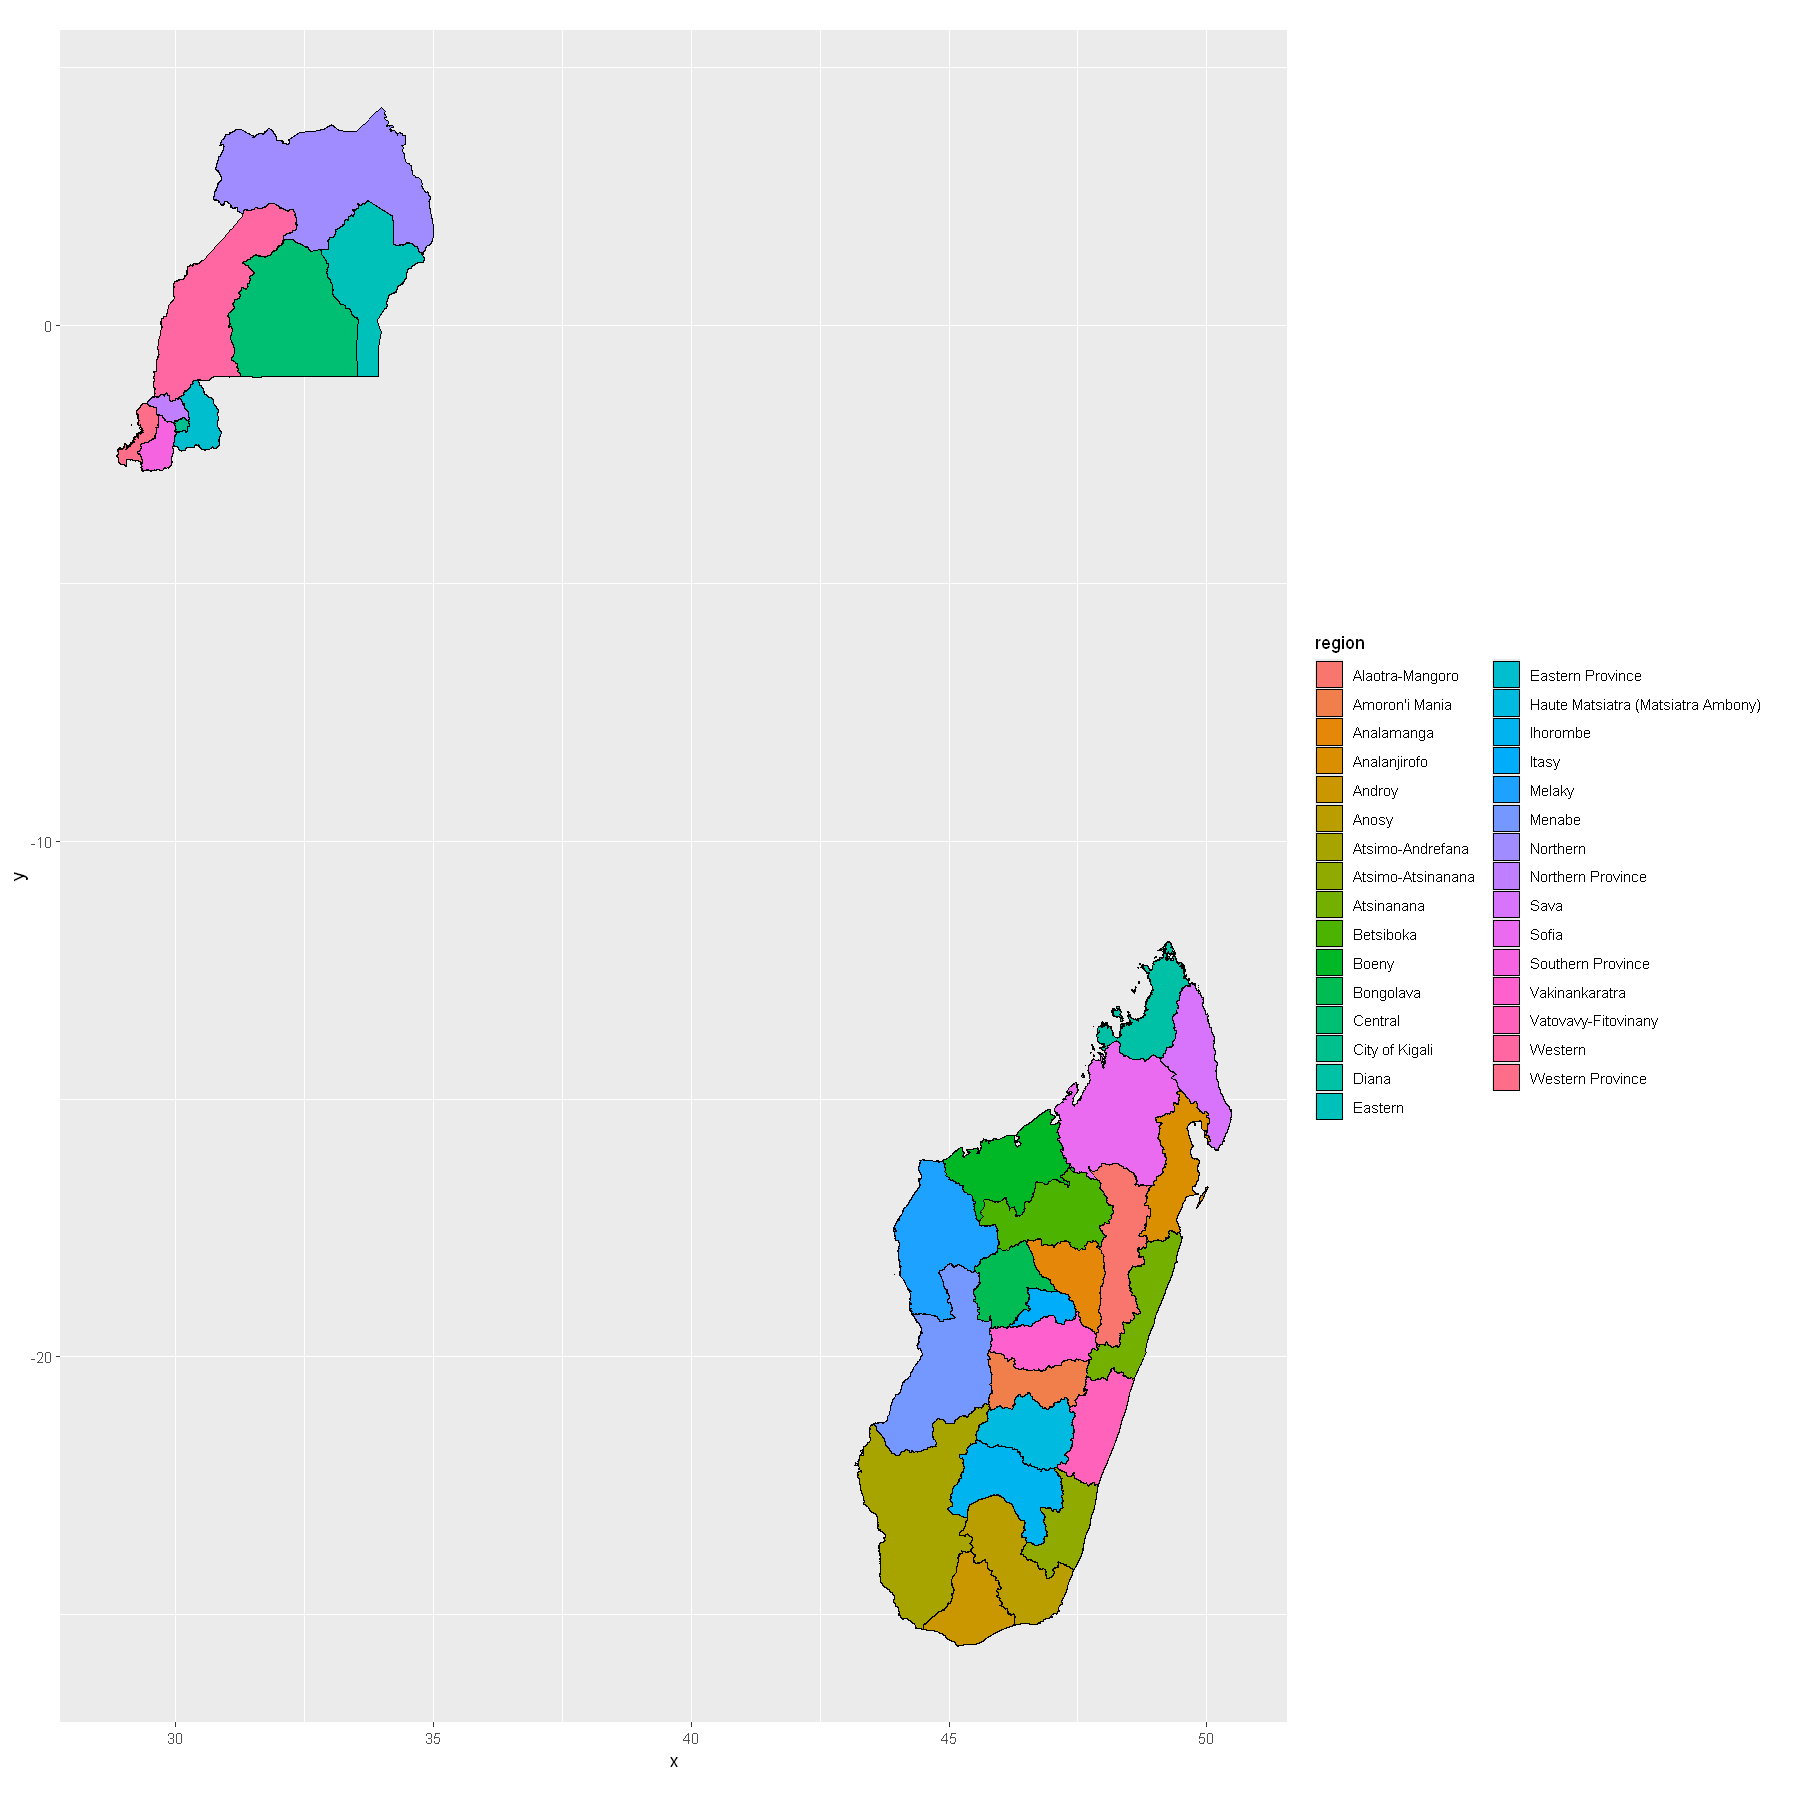

In [7]:
options(repr.plot.height=15,repr.plot.width=15)
ggplot(df.geo.regions,aes(x,y,fill=region,group=path.id)) + geom_polygon(color="black") + coord_fixed() #+ theme(legend.position="none")

### 4. Checking the resulting dataframe

In [8]:
df.geo.regions %>% group_by(country) %>% summarize(regions.No=n_distinct(region))

country,regions.No
<chr>,<int>
Madagascar,22
Rwanda,5
Uganda,4


In [9]:
unique(df.uganda$region)

[1] "Central"  "Eastern"  "Northern" "Western"

In [10]:
unique(df.rwanda$region)

[1] "Eastern Province"  "City of Kigali"    "Northern Province"
[4] "Southern Province" "Western Province"

In [11]:
sort(unique(df.madagascar$region))

[1] "Alaotra-Mangoro"                    "Amoron'i Mania"                    
 [3] "Analamanga"                         "Analanjirofo"                      
 [5] "Androy"                             "Anosy"                             
 [7] "Atsimo-Andrefana"                   "Atsimo-Atsinanana"                 
 [9] "Atsinanana"                         "Betsiboka"                         
[11] "Boeny"                              "Bongolava"                         
[13] "Diana"                              "Haute Matsiatra (Matsiatra Ambony)"
[15] "Ihorombe"                           "Itasy"                             
[17] "Melaky"                             "Menabe"                            
[19] "Sava"                               "Sofia"                             
[21] "Vakinankaratra"                     "Vatovavy-Fitovinany"

In [12]:
rbind(head(df.geo.regions %>% filter(country=="Rwanda")),
      head(df.geo.regions %>% filter(country=="Uganda")),
      head(df.geo.regions %>% filter(country=="Madagascar"))
     )

x,y,region,path.id,point.ix,country
<dbl>,<dbl>,<chr>,<dbl>,<int>,<chr>
30.44970,-1.049094,Eastern Province,1,1,Rwanda
30.44998,-1.049565,Eastern Province,1,2,Rwanda
30.45002,-1.049227,Eastern Province,1,3,Rwanda
30.45005,-1.048911,Eastern Province,1,4,Rwanda
30.45008,-1.048537,Eastern Province,1,5,Rwanda
30.45076,-1.048452,Eastern Province,1,6,Rwanda
32.22046,1.670968,Central,64,1,Uganda
32.22140,1.670771,Central,64,2,Uganda
32.22305,1.670426,Central,64,3,Uganda


### 5. Exporting the resulting dataframe to RData file

In [13]:
save(df.geo.regions, file = "data/df_geo_regions.RData")